In [1]:
# necessary modules
import sqlite3
import utils
import recommender_classifier
import evaluation
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from multiprocessing import Pool, Process, Manager
from pylab import MaxNLocator

In [2]:
# load random users and feature vectors
conn = sqlite3.connect('database.db')
Users = utils.selectRandomUsers(conn)
LOW_LEVEL_FEATURES, DEEP_FEATURES_RESNET, HYBRID_FEATURES_RESNET = utils.extract_features()
foo, DEEP_FEATURES_BOF, HYBRID_FEATURES_BOF = utils.extract_features('bof_128.bin')
# USER_TFIDF_FEATURES, MOVIE_TFIDF_FEATURES = utils.extract_tfidf_features()

print len(Users)

user_profiles = recommender_classifier.build_user_profiles(conn, Users)

138


In [3]:
def run(user_profiles, N, feature_vector, feature_vector2=None):

    conn = sqlite3.connect('database.db')
    
    SumRecall, SumPrecision = 0, 0
    
    for user, profile in user_profiles.iteritems():                
        
        if feature_vector2 is not None:
            if np.sum(feature_vector[user]) == 0:
                print "Blank user profile", user
                continue
        
        hits = 0
        
        predictions = recommender_classifier.get_predict_collaborative_filtering(conn, profile, feature_vector, feature_vector2)
        # print "Predictions", sorted(predictions, key=lambda tup: tup[2], reverse=True)
        
        for elite_movie in profile['datasets']['elite_test']:
                        
            if feature_vector is list and elite_movie[0] not in feature_vector:
                continue
                
            # Predict to the user movie and to random movies that the user did not rated
            # print predictions            
            elite_prediction = recommender_classifier.get_prediction_elite(conn, elite_movie, profile, feature_vector, feature_vector2)
            all_predictions = predictions[:]
            all_predictions.append(elite_prediction)
            
            # print "Elite Movie", elite_movie, elite_prediction
            
            hits += recommender_classifier.count_hit(all_predictions, elite_movie, N)
        try:
            recall = hits / float(len(profile['datasets']['elite_test']))
            SumRecall += recall
            SumPrecision += (recall / float(N))
        except ZeroDivisionError:
            continue
        # print "Size is", len(predictions)
        # print "Predictions", sorted(predictions, key=lambda tup: tup[2], reverse=True)

    size = len(user_profiles)
    avgRecall = utils.evaluateAverage(SumRecall, size)
    avgPrecision = utils.evaluateAverage(SumPrecision, size)

    return avgPrecision, avgRecall

In [4]:
# def experiment(N, user_profiles_low_level, LOW_LEVEL_FEATURES, user_profiles_deep, DEEP_FEATURES):
def experiment(N, res_ll,res_deep,res_hybrid,res_random,res_deep_bof,res_hybrid_bof):
    
    global user_profiles, LOW_LEVEL_FEATURES, DEEP_FEATURES_RESNET, HYBRID_FEATURES_RESNET, DEEP_FEATURES_BOF, HYBRID_FEATURES_BOF
    
    result = {}
    start = time.time()
    
    # Tag-based
    # p_t, r_t = run(user_profiles, N, USER_TFIDF_FEATURES, MOVIE_TFIDF_FEATURES)
    # print "Tag-based Recall", r_t, "Tag-based Precision", p_t, "For iteration with", N
    
    # LOW LEVEL FEATURES check precision, recall and mae
    p_l, r_l = run(user_profiles, N, LOW_LEVEL_FEATURES)
    res_ll[N] = {'ll': {'recall': r_l, 'precision': p_l} }
    print "Low-Level Recall", r_l, "Low-Level Precision", p_l, "For iteration with", N
        
    # end = time.time()
    # print "Execution time", (end - start)

    # start = time.time()
    # DEEP FEATURES - RESNET
    p_d, r_d = run(user_profiles, N, DEEP_FEATURES_RESNET)
    res_deep[N] = {'deep_resnet': {'recall': r_d, 'precision': p_d} }
    print "Deep Resnet Recall", r_d, "Deep Resnet Precision", p_d, "For iteration with", N        
    
    # HYBRID - RESNET
    p_h, r_h = run(user_profiles, N, HYBRID_FEATURES_RESNET)
    res_hybrid[N] = {'hybrid_resnet': {'recall': r_h, 'precision': p_h}}
    print "Hybrid Resnet Recall", r_h, "Hybrid Resnet Precision", p_h, "For iteration with", N
    
    # DEEP FEATURES - BOF
    p_d, r_d = run(user_profiles, N, DEEP_FEATURES_BOF)
    res_deep_bof[N] = {'deep_bof': {'recall': r_d, 'precision': p_d} }
    print "Deep BOF Recall", r_d, "Deep BOF Precision", p_d, "For iteration with", N        
    
    # HYBRID - BOF
    p_h, r_h = run(user_profiles, N, HYBRID_FEATURES_BOF)
    res_hybrid_bof[N] = {'hybrid_bof': {'recall': r_h, 'precision': p_h}}
    print "Hybrid BOF Recall", r_h, "Hybrid BOF Precision", p_h, "For iteration with", N    

    p, r, mae = recommender_classifier.recommend_random(user_profiles, N)
    res_random[N] = {'random': {'recall': r, 'precision': p}}
    print "Random Recall", r, "Random Precision",  p, "Random MAE", mae, "For iteration with", N
    
    # return_dict[N] = {'ll': {'recall': r_l, 'precision': p_l}, 'deep': {'recall': r_d, 'precision': p_d}, 'hybrid': {'recall': r_h, 'precision': p_h}, 'random': {'recall': r, 'precision': p}}    
    end = time.time()
    print "Execution time", (end - start)
    
#     result = {'ll': {'recall': r_l, 'precision': p_l}, 'deep': {'recall': r_d, 'precision': p_d}, 'random': {'recall': r, 'precision': p}}
   

In [5]:
iterations = range(1, 11)

# experiment(1)
manager = Manager()
res_ll = manager.dict()
res_deep = manager.dict()
res_hybrid = manager.dict()
res_deep_bof = manager.dict()
res_hybrid_bof = manager.dict()
res_random = manager.dict()

jobs = []
for num in iterations:
    p = Process(target=experiment, args=(num,res_ll,res_deep,res_hybrid,res_random,res_deep_bof,res_hybrid_bof))
    jobs.append(p)
    p.start()

for proc in jobs:
    proc.join()
# print return_dict.values()

# p = Pool(5)
# print(p.map(experiment, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))

Low-Level Recall 0.10809258082 Low-Level Precision 0.021618516164 For iteration with 5
Low-Level Recall 0.0597199657806 Low-Level Precision 0.0298599828903 For iteration with 2
Low-Level Recall 0.0875538602811 Low-Level Precision 0.0218884650703 For iteration with 4
Low-Level Recall 0.041181041181 Low-Level Precision 0.041181041181 For iteration with 1
Low-Level Recall 0.0832889893496 Low-Level Precision 0.0277629964499 For iteration with 3
Deep Resnet Recall 0.0760221260221 Deep Resnet Precision 0.0380110630111 For iteration with 2
Deep Resnet Recall 0.172773634895 Deep Resnet Precision 0.034554726979 For iteration with 5
Deep Resnet Recall 0.161895624017 Deep Resnet Precision 0.0404739060042 For iteration with 4
Deep Resnet Recall 0.0265271765272 Deep Resnet Precision 0.0265271765272 For iteration with 1
Deep Resnet Recall 0.126119054907 Deep Resnet Precision 0.042039684969 For iteration with 3
Hybrid Resnet Recall 0.0826599326599 Hybrid Resnet Precision 0.04132996633 For iteration w

In [17]:
low_level_recall = [item['ll']['recall'] for item in res_ll.values()]
deep_recall = [item['deep_resnet']['recall'] for item in res_deep.values()]
hybrid_recall = [item['hybrid_resnet']['recall'] for item in res_hybrid.values()]
deep_bof_recall = [item['deep_bof']['recall'] for item in res_deep_bof.values()]
hybrid_bof_recall = [item['hybrid_bof']['recall'] for item in res_hybrid_bof.values()]
random_recall = [item['random']['recall'] for item in res_random.values()]

print low_level_recall
print deep_recall
# print low_level_recall

for key, value in res_ll.items():
     print "Entry", key, value

with open('results_testing.txt', 'a') as resfile:
    for key, value in res_ll.items():
        resfile.write(str(key)+str(value)+"\n")
    # for key, value in res_deep.items():
    #     resfile.write(str(key) + str(value))
    # for key, value in res_hybrid.items():
    #     resfile.write(str(key) + str(value))
    for key, value in res_deep_bof.items():
        resfile.write(str(key) + str(value)+"\n")
    for key, value in res_hybrid_bof.items():
        resfile.write(str(key) + str(value)+"\n")
    for key, value in res_random.items():
        resfile.write(str(key) + str(value)+"\n")

[0.04118104118104118, 0.059719965780571836, 0.08328898934959539, 0.08755386028113299, 0.10809258081985354]
[0.026527176527176528, 0.07602212602212602, 0.1261190549069337, 0.16189562401683616, 0.172773634894847]
Entry 1 {'ll': {'recall': 0.04118104118104118, 'precision': 0.04118104118104118}}
Entry 2 {'ll': {'recall': 0.059719965780571836, 'precision': 0.029859982890285918}}
Entry 3 {'ll': {'recall': 0.08328898934959539, 'precision': 0.027762996449865136}}
Entry 4 {'ll': {'recall': 0.08755386028113299, 'precision': 0.021888465070283247}}
Entry 5 {'ll': {'recall': 0.10809258081985354, 'precision': 0.02161851616397071}}


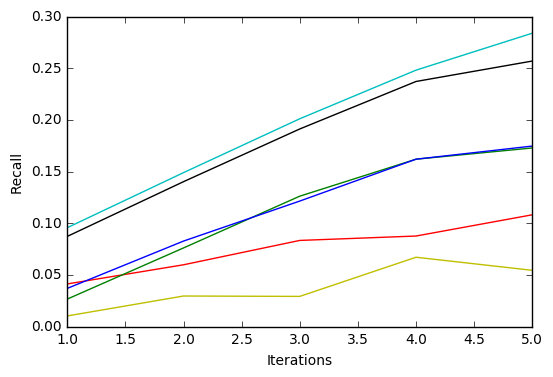

In [9]:
plt.plot(iterations, low_level_recall, 'r-', iterations, deep_recall, 'g-', iterations, hybrid_recall, 'b-', iterations, deep_bof_recall, 'c-', iterations, hybrid_bof_recall, 'k-', iterations, random_recall, 'y-')
plt.ylabel('Recall')
plt.xlabel('Iterations')
plt.show()

iterations = range(1, 6)
plt.plot(iterations, low_level_recall, 'r-', iterations, deep_recall, 'g-', iterations, hybrid_recall, 'b-', iterations, deep_bof_recall, 'c-', iterations, hybrid_bof_recall, 'k-', iterations, random_recall, 'y-')
plt.ylabel('Recall')
plt.xlabel('Iterations')
plt.show()

# fig, ax = plt.subplots()

# # Be sure to only pick integer tick locations.
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

# # Plot anything (note the non-integer min-max values)...
# x = np.linspace(-0.1, np.pi, 100)
# ax.plot(range(1,6), low_level_recall, 'r--', range(1,6), deep_recall, 'g--', range(1,6), hybrid_recall, 'b--', range(1,6), random_recall, 'y--')

# # Just for appearance's sake
# ax.margins(0.05)
# ax.axis('tight')
# fig.tight_layout()

# plt.show()
